In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import cfg
import functools
from typing import List
from src import agents, prompts, states, tools, members
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

/home/saurabh/anaconda3/envs/llm_agent/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The function `convert_pydantic_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.3.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


#### Define Model

In [3]:
llm = cfg.llm

In [4]:
## Supervisor prompt
supervisor_template = prompts.supervisor_template.partial(members = members.members,
                                                  options = members.options)

## Create agent
supervisor_chain = agents.create_supervisor_agent(llm, prompt_template = supervisor_template, 
                               functions = members.functions,
                               function_call= members.function_call)

research_agent = agents.create_agent(llm , tools = [tools.tavily_tool], prompt_template=prompts.researcher_template)
coder_agent = agents.create_agent(llm, tools=[tools.python_repl_tool], prompt_template=prompts.coder_template)

## Create Node
research_node = functools.partial(agents.agent_node, name = "Researcher", agent = research_agent)
coder_node = functools.partial(agents.agent_node, name = "Coder", agent = coder_agent)

In [5]:
## Test the node
# research_node(state= {"messages": [HumanMessage(content="What is langchain")]})

In [6]:
## Create Graph
workflow = StateGraph(states.State)
# Add Node
workflow.add_node('Researcher', research_node)
workflow.add_node('Coder', coder_node)
workflow.add_node('supervisor', supervisor_chain)
# Add Edge
_ = [workflow.add_edge(member, 'supervisor') for member in members.members]
conditional_map = {k:k for k in members.options}
conditional_map['FINISH'] = END

workflow.add_conditional_edges('supervisor',
                        lambda x: x['next'],
                        conditional_map
                        )


workflow.add_edge(START, 'supervisor')
# Compile Graph
graph = workflow.compile()

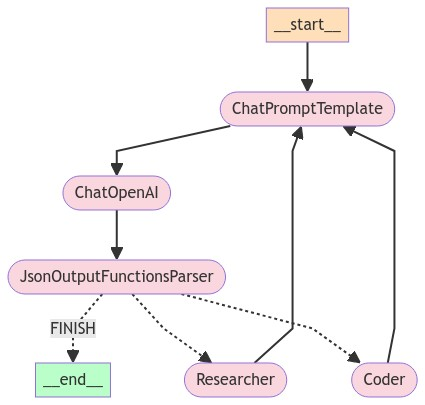

In [7]:
# Display graph
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Outputs

In [9]:
input = "Generate the python program to swap 2 numbers?"

events = graph.stream(
    {"messages": [HumanMessage(content=input)]},
    {"recursion_limit": 20},
)

for s in events:
    print(s)
    print("----")

{'supervisor': {'next': 'Coder'}}
----
{'Coder': {'messages': [HumanMessage(content='FINAL ANSWER:\n\nHere is the Python program to swap two numbers:\n\n```python\ndef swap_numbers(a, b):\n    a, b = b, a\n    return a, b\n\n# Testing the function\nx = 5\ny = 10\nx, y = swap_numbers(x, y)\nprint(f"Swapped values: x = {x}, y = {y}")\n```\n\nWhen executed, the output is:\n```\nSwapped values: x = 10, y = 5\n```', name='Coder')]}}
----
{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='Here is a Python program to swap two numbers:\n\n```python\ndef swap_numbers(a, b):\n    a, b = b, a\n    return a, b\n\n# Testing the function\nx = 5\ny = 10\nx, y = swap_numbers(x, y)\nprint(f"Swapped values: x = {x}, y = {y}")\n```\n\nWhen you run this code, the output will be:\n```\nSwapped values: x = 10, y = 5\n```\n\nThis program defines a function `swap_numbers` that swaps the values of two variables `a` and `b`. It then tests this function by swapping the

## Invoke

In [10]:
result = graph.invoke(
    {"messages": [HumanMessage(content=input)]},
    {"recursion_limit": 20},
)

In [11]:
print(result['messages'][-1].content)

The Python program to swap two numbers was successfully executed. Here is the code:

```python
def swap_numbers(a, b):
    print(f"Original numbers: a = {a}, b = {b}")
    # Swapping using a temporary variable
    temp = a
    a = b
    b = temp
    print(f"Swapped numbers: a = {a}, b = {b}")
    return a, b

# Test the function with example values
a = 5
b = 10
swap_numbers(a, b)
```

Output:
```
Original numbers: a = 5, b = 10
Swapped numbers: a = 10, b = 5
```

FINAL ANSWER
